This notebook shows the dependencies required to obtain Azimuth and Zenith angles of the neutrinos detected for an event.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.4 MB/s eta 0:00:00


In [3]:
import pandas as pd

In [4]:
from fastparquet import ParquetFile

In [5]:
pf = ParquetFile("/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet")
b1df=pf.to_pandas()

In [6]:
tm = pd.read_parquet("/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet")

In [7]:
sensordf=pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')

In [8]:
tm.batch_id.value_counts()

1      200000
435    200000
437    200000
438    200000
439    200000
        ...  
221    200000
222    200000
223    200000
224    200000
660    153924
Name: batch_id, Length: 660, dtype: int64

In [9]:
sensordf.describe()

,sensor_id,x,y,z
count,5160.000000,5160.000000,5160.000000,5160.000000
mean,2579.500000,5.870829,-2.518609,-23.905766
std,1489.708025,285.151213,269.409729,296.456563
min,0.000000,-570.900000,-521.080000,-512.820000
25%,1289.750000,-224.090000,-209.070000,-283.200000
50%,2579.500000,16.990000,-6.055000,-35.115000
75%,3869.250000,224.580000,211.660000,228.557500
max,5159.000000,576.370000,509.500000,524.560000


In [10]:
import matplotlib.pyplot as plt

In [11]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [12]:
import scipy

In [13]:
from scipy.special import huber

In [14]:
b1df['elapsed_time']=b1df['time']-5928

In [15]:
b1df['vel_dist']=1.58*(0.1)*b1df['elapsed_time']

In [16]:
import sklearn

In [17]:
r=list(dict(b1df.sensor_id.value_counts()))

In [18]:
from sklearn.linear_model import HuberRegressor
from sklearn.datasets import make_regression

In [19]:
def predangle(df):
    p=[]
    p1c=np.cov(df['z'],df['x'])
    a1=p1c[0][1]/p1c[0][0]
    p2c=np.cov(df['z'],df['y'])
    a2=p2c[0][1]/p2c[0][0]
    d=np.sqrt(1+a1**2+a2**2)
    azimuth=np.arctan2(a2,a1)
    if azimuth<0:
        azimuth=2*np.pi+azimuth
    zenith=np.arccos(1/d)
    p.append([azimuth,zenith])
    return p

In [20]:
testdf=ParquetFile('/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet')
testdata=testdf.to_pandas()

In [21]:
testdata

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


In [22]:
event5=5
event5_pulse_info=b1df.iloc[tm.iloc[event5].first_pulse_index.astype(int):tm.iloc[event5].last_pulse_index.astype(int)+1].copy()

In [23]:
event5_pulse_info.head()

,sensor_id,time,charge,auxiliary,elapsed_time,vel_dist
event_id,,,,,,
77,3196,5976,0.825,True,48,7.584
77,724,6537,1.075,True,609,96.222
77,4967,6648,0.375,True,720,113.760
77,1165,6687,0.675,True,759,119.922
77,4974,6901,0.375,True,973,153.734


In [24]:
event5_pulse_info = event5_pulse_info.reset_index()
event5_pulse_info[['x', 'y', 'z']] = sensordf.loc[event5_pulse_info.sensor_id].reset_index()[['x','y','z']]


In [25]:
event5_pulse_info.head()

,event_id,sensor_id,time,charge,auxiliary,elapsed_time,vel_dist,x,y,z
0,77,3196,5976,0.825,True,48,7.584,-111.51,159.98,228.20
1,77,724,6537,1.075,True,609,96.222,405.83,-306.38,427.05
2,77,4967,6648,0.375,True,720,113.760,113.19,-60.47,-420.42
3,77,1165,6687,0.675,True,759,119.922,326.85,-209.07,72.91
4,77,4974,6901,0.375,True,973,153.734,113.19,-60.47,-469.48


In [26]:
p_angle=predangle(event5_pulse_info)

In [27]:
p_angle

[[2.09795086092426, 0.23583205960557974]]

In [28]:
def errorpred(true_az,pred_az,true_zen,pred_zen):
    e=[]
    da=abs(true_az-pred_az)
    db=abs(true_zen-pred_zen)
    e.append(da)
    e.append(db)
    return e

In [29]:
e=errorpred(tm['azimuth'][event5],p_angle[0][0],tm['zenith'][event5],p_angle[0][1])

In [30]:
e

[2.0865793485351247, 1.0595386941772862]

In [31]:
b1df.auxiliary.value_counts()

False    23551893
True      9240523
Name: auxiliary, dtype: int64

In [32]:
b1df.tail()

,sensor_id,time,charge,auxiliary,elapsed_time,vel_dist
event_id,,,,,,
3266196,1961,17617,0.975,True,11689,1846.862
3266196,36,17705,0.625,True,11777,1860.766
3266196,356,18192,0.725,True,12264,1937.712
3266196,2826,18609,0.575,True,12681,2003.598
3266196,5013,18741,1.375,True,12813,2024.454


Following the estimation of angle through the use of coordinates of sensors, a similar direction tracing through the overall distance covered in a batch of events would be understood. Each batch would have the estimated number of bouncing on the sensors followed from a muon hit and radiation emitted to obtain the looping.

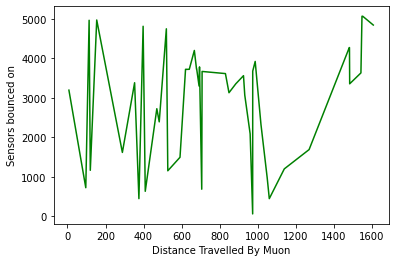

In [33]:
plt.xlabel('Distance Travelled By Muon')
plt.ylabel('Sensors bounced on')
plt.plot(event5_pulse_info['vel_dist'],event5_pulse_info['sensor_id'], color="green")

In [34]:
def distcovered(df):
    l=len(df)
    dist=[]
    for i in range(l-1):
        p1=[df['x'][i+1],df['y'][i+1],df['z'][i+1]]
        p2=[df['x'][i],df['y'][i],df['z'][i]]
        dist.append(((((p2[0]-p1[0])**2)+((p2[1]-p1[1])**2)+((p2[2]-p1[2])**2))**0.5)+df['vel_dist'][i])
    dist.append(df['vel_dist'][l-1])
    return dist

In [35]:
d=distcovered(event5_pulse_info)

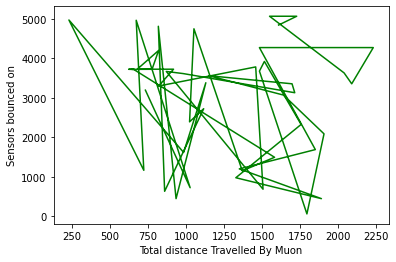

In [36]:
plt.xlabel('Total distance Travelled By Muon')
plt.ylabel('Sensors bounced on')
plt.plot(d,event5_pulse_info['sensor_id'], color="green")

In [37]:
dn=np.array(d)

In [38]:
dd=dn.reshape(-1,1)

In [39]:
huberpred = HuberRegressor().fit(dd,event5_pulse_info['auxiliary'])

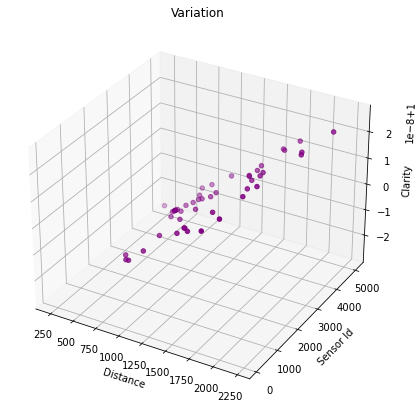

In [40]:
fig1=plt.figure()
fig1.set_figwidth(7)
fig1.set_figheight(7)
ax1 = plt.axes(projection ='3d')
ax1.set_xlabel('Distance')
ax1.set_ylabel('Sensor Id')
ax1.set_zlabel('Clarity')
ax1.set_title('Variation')
ax1.scatter3D(d,event5_pulse_info['sensor_id'],huberpred.predict(dd),color='purple')


In [41]:
sensor=np.array(event5_pulse_info['sensor_id'])

The path can be deduced following the distance covered by the pulse via each sensor and clarity of the signal when auxiliary=false through a line fit. They would be mapped to the path observed through the recorded azimuth and zenith angle. The fit score will be analysed on each batch on the set of events,to obtain the appropriate line fit based on the statistical convergence of the events in each batch.

In [42]:
event5_pulse_info['x_norm']=(event5_pulse_info['x']-np.min(event5_pulse_info['x']))/(np.max(event5_pulse_info['x'])-np.min(event5_pulse_info['x']))

In [43]:
event5_pulse_info['y_norm']=(event5_pulse_info['y']-np.min(event5_pulse_info['y']))/(np.max(event5_pulse_info['y'])-np.min(event5_pulse_info['y']))

In [44]:
event5_pulse_info['z_norm']=(event5_pulse_info['z']-np.min(event5_pulse_info['z']))/(np.max(event5_pulse_info['z'])-np.min(event5_pulse_info['z']))

In [45]:
import math
import warnings
warnings.filterwarnings('ignore')

In [46]:
def bouncedir(d1,d2,d3):
    p=[]
    if d1==0:
        azimuth=np.pi/2
    else:
        azimuth=math.atan(d2/d1)
    if azimuth<0:
        azimuth=2*np.pi+azimuth
    zenith=math.acos(d3)
    p.append([azimuth,zenith])
    return p

In [47]:
l=len(event5_pulse_info)
y1=[]
y2=[]
for i in range(l):
    p=bouncedir(event5_pulse_info['x_norm'][i],event5_pulse_info['y_norm'][i],event5_pulse_info['z_norm'][i])
    y1.append(p[0][0])
    y2.append(p[0][1])

A Multiple Linear Regression Model to Understand the relationship between distance travelled by the muon, sensors hit, clarity of the signal to derive the azimuth and zenith angle tracked through each muon would be trained.

In [48]:
r=int(0.75*l)
tr5=event5_pulse_info[0:r]
te5=event5_pulse_info[r:l]

In [49]:

from sklearn.linear_model import LinearRegression

In [50]:
yn=np.array(y2)

In [51]:
ys=yn.reshape(-1,1)

In [52]:
hl=list(huberpred.predict(dd)[0:r])

In [53]:
hlt=list(huberpred.predict(dd)[r:l])

In [54]:
ndf=tr5

In [55]:
ntdf=te5

In [56]:
ndf['total_dist']=d[0:r]

In [57]:
ntdf['total_dist']=d[r:l]

In [58]:
ntdf['predict_clarity']=hlt

In [59]:
ndf['predict_clarity']=hl

In [60]:
reg=LinearRegression()

In [61]:
regz=LinearRegression()

In [62]:
reg.fit(ndf[['total_dist','sensor_id','predict_clarity']],y1[0:r])

LinearRegression()

In [63]:
reg.intercept_

0.017172538664791515

In [64]:
paz=reg.predict(ntdf[['total_dist','sensor_id','predict_clarity']])

In [65]:
paz

array([1.2199058 , 0.90988344, 0.51534215, 0.51341545, 0.57069274,
       0.78566385, 1.29229163, 1.44892248, 1.21202346, 1.26384021,
       1.48549326, 1.52282298, 1.4475877 ])

In [66]:
np.array(y1[r:l])

array([0.88143464, 0.57664497, 0.56755911, 0.43203526, 0.35834148,
       0.49758229, 1.06915158, 1.06915158, 0.92551585, 1.41636101,
       0.81430781, 0.81430781, 0.87763506])

In [67]:
regz.fit(ndf[['total_dist','sensor_id','predict_clarity']],y2[0:r])

LinearRegression()

In [68]:
pr=regz.predict(ntdf[['total_dist','sensor_id','predict_clarity']])

In [69]:
pr

array([0.89112699, 0.91623924, 0.83052699, 0.92036595, 0.83658391,
       0.92580369, 0.88903613, 1.01548265, 0.98253838, 0.97677548,
       0.90808677, 0.93822268, 0.9159406 ])

In [70]:
np.array(y2[r:l])

array([0.92498096, 1.37294393, 0.78294058, 1.00505719, 0.02907668,
       0.59128181, 0.72662848, 0.72662848, 1.54452572, 1.11982422,
       1.36403657, 1.36403657, 1.48682255])

The predicted direction for each sensor through azimuth and zenith angle at the bouncing point taken on events used for training would be used to deduce the spotted positions, x, y, z coordinates for events in test to arrive at their azimuth and zenith angle.